In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-01_09-01_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.20512820512820512

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.25
GC       0.25
ES       0.25
YM       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES     4781.90
GC    -3213.52
NQ    21011.20
YM    28630.20
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

51209.78

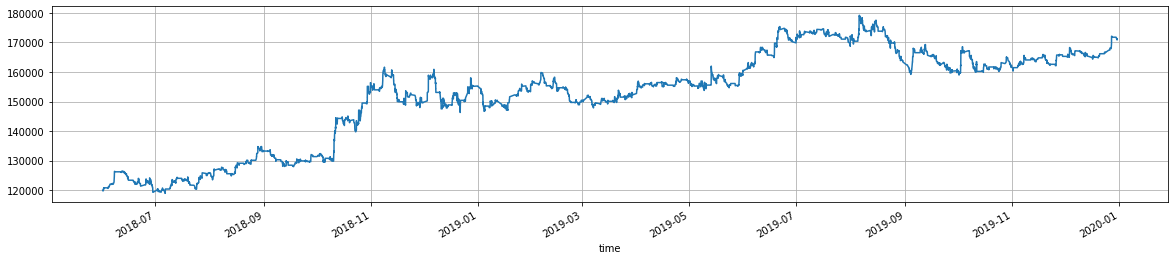

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     837
 GC    1456
 NQ    2328
 YM     839
 Name: action, dtype: int64,
 5460)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    2.031553
 GC    3.533981
 NQ    5.650485
 YM    2.036408
 Name: action, dtype: float64,
 13.25242718446602)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1757.70
GC    3523.52
NQ    4888.80
YM    1761.90
Name: commission, dtype: float64

In [16]:
df.commission.sum()

11931.92

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.38,-4.41,415.31,-257.73,1.61,-1.97,728.0
NQ,0.39,18.05,438.26,-252.59,1.74,16.84,1164.0
ES,0.42,11.44,697.59,-482.70,1.45,13.02,418.0
YM,0.42,68.33,678.63,-369.38,1.84,70.78,419.0
total,0.40,18.77,513.40,-305.19,1.68,22.25,2729.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.053739,0.294659,0.490722,0.759114
GC,0.053739,1.000000,0.026632,0.062499,0.358336
NQ,0.294659,0.026632,1.000000,0.289274,0.669086
YM,0.490722,0.062499,0.289274,1.000000,0.736326
total,0.759114,0.358336,0.669086,0.736326,1.000000


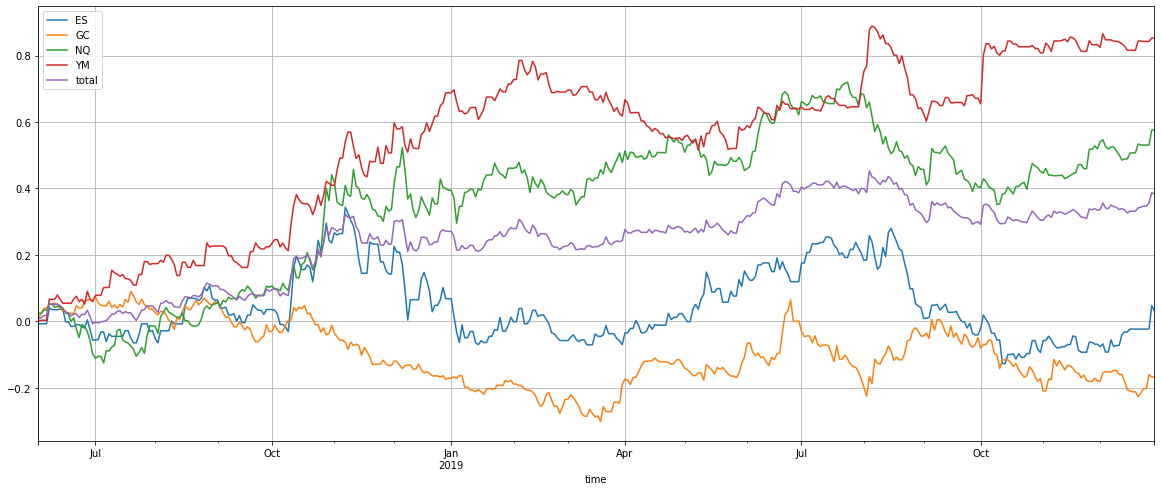

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

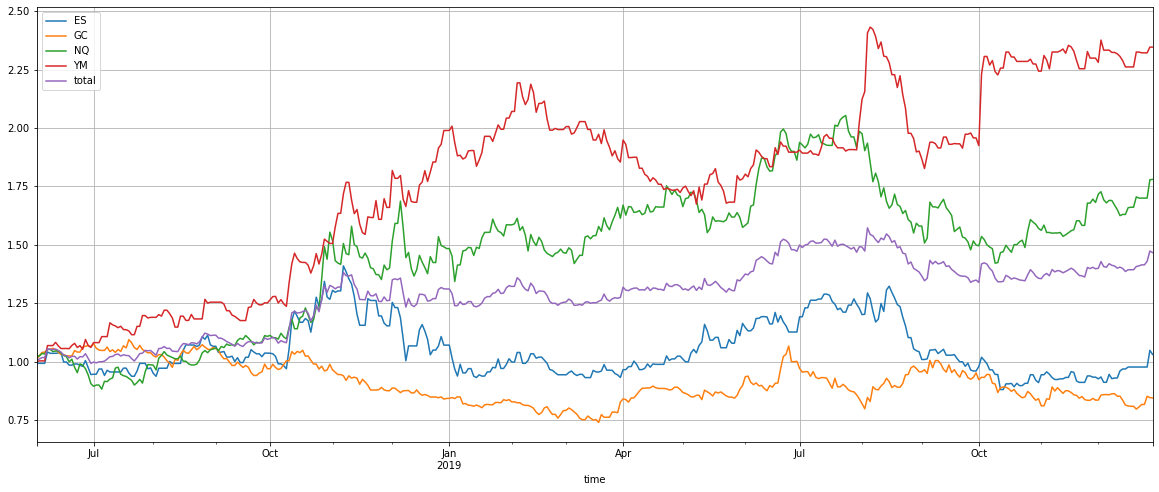

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.018782,-0.098050,0.422823,0.684587,0.264100
Cumulative returns,0.030889,-0.155253,0.779875,1.345843,0.466913
Annual volatility,0.400140,0.276124,0.391658,0.356414,0.232166
Sharpe ratio,0.243652,-0.237279,1.093770,1.637764,1.124286
Calmar ratio,0.050034,-0.302785,1.374092,2.750928,1.779018
Stability,0.005313,0.271426,0.646751,0.786845,0.735975
Max drawdown,-0.375380,-0.323829,-0.307711,-0.248857,-0.148452
Omega ratio,1.048945,0.959116,1.221458,1.403630,1.239998
Sortino ratio,0.389238,-0.377796,1.844861,3.228938,2.005133
Skew,0.801013,0.931113,0.800062,1.806765,1.244055


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,-5.52,6.38,-9.42,6.09,-0.71
2018-07-31,3.02,-2.38,8.86,12.13,5.54
2018-08-31,9.50,2.17,6.85,5.45,6.22
2018-09-30,-2.74,-8.60,5.16,-0.26,-1.61
2018-10-31,22.17,1.92,40.29,20.35,21.08
2018-11-30,-8.93,-11.40,-9.89,10.24,-4.79
2018-12-31,-7.16,-3.77,5.95,19.84,3.84
2019-01-31,-5.44,-0.61,6.83,2.67,1.11
2019-02-28,-6.77,-5.61,-7.50,-2.41,-5.41


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES         3.0
GC       -16.0
NQ        78.0
YM       135.0
total     47.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:00:30,YM,BUY,25991.00,4750.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
2018-10-31 15:48:00,NQ,SELL,6989.50,2965.80
2018-11-20 16:41:30,ES,BUY,2659.75,2958.30
2018-12-03 15:47:00,YM,SELL,25943.00,2855.80
...,...,...,...,...
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20
2018-12-07 14:41:30,ES,BUY,2698.00,-1354.20
2018-12-21 00:01:30,ES,BUY,2488.75,-1391.70


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-12-03,0.086943,0.013516,0.082273,0.095193,0.069481
2019-08-05,0.075553,0.060849,0.017100,0.116553,0.067514
2018-10-11,0.113607,0.039193,0.031493,0.061133,0.061357
2019-10-02,0.040553,0.011183,0.026633,0.158360,0.059182
2019-09-05,0.037360,0.059183,0.100720,0.030053,0.056829
...,...,...,...,...,...
2018-11-13,-0.040280,0.004344,-0.049813,-0.034920,-0.030167
2018-11-15,-0.039587,-0.028151,-0.029340,-0.038113,-0.033798
2019-01-03,-0.047087,-0.004828,-0.074813,-0.035113,-0.040460
